In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_utils import BasicFunctions, PriceFunctions
from TechnicalAnalysis import TechnicalAnalysis 
from BackTest import Backtester, strategyBacktest
import math
import tensorflow as tf
from scipy.stats import linregress

from IPython.display import HTML

import os
from datetime import datetime

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import time
import datetime

In [6]:
from keras.layers import Input, Embedding, Average, Dense, Conv1D, MaxPooling1D, LSTM, BatchNormalization, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.models import Model
import keras.backend as K

In [7]:
bf = BasicFunctions()
pf = PriceFunctions()

In [8]:
def addIrregularFeatures(df_coin, irregular_data):
    '''
    Parameters:
    ___________
    
    df_coin (DataFrame):
    Dataframe of coin with date as the index.
    
    irregular_data(DataFrame):
    Dataframe with Date as column
    
    Returns:
    Dataframe the same size as df_coin with same date and features from irregular_data at the closest time - forward filled
    '''
    newDf = pd.DataFrame(columns=['Date'])
    newDf['Date'] = df_coin.index
    
    closestDf = pd.DataFrame(columns=['Date'])

    
    #replace with closest date
    for i in range(irregular_data['Date'].shape[0]):
        closestDf = closestDf.append({'Date': newDf.iloc[(newDf['Date'] - irregular_data['Date'].iloc[i]).abs().argsort()[0]]['Date']}, ignore_index=True)
    
    
    newTrends = irregular_data
    newTrends['Date'] = closestDf['Date']

    newTrends = newTrends.set_index('Date')
    newDf = newDf.set_index('Date')
    
    newTrends = newTrends[~newTrends.index.duplicated(keep='last')] #replace duplicates
    test = newDf.join(newTrends).ffill()
    
    return test #can add unit test if time

def add_trends(df, coinfull):
    '''
    Parameters:
    df (Dataframe):
    Dataframe containing coin price and all

    coinfull (string):
    Full name in small like bitcoin
    '''
    trend = pd.read_csv('data_utils\\trends_data\\{}.csv'.format(coinfull))
    trend = trend[::-1] #reverse
    trend = trend.reset_index(drop=True)
    
    trend['Date'] = trend['date'].apply(lambda x: int(time.mktime(datetime.datetime.strptime(x, "%Y-%M-%d").timetuple())))
    trend = trend.drop('date', axis=1)
    
    trend = trend.rename(columns={coinfull: 'Google Trend'})
    
    regFeatures = addIrregularFeatures(df, trend.drop('isPartial', axis=1))
    
    df = df.join(regFeatures)
    
    return df

def add_wikipedia(df, coinfull):
    '''
    Parameters:
    df (Dataframe):
    Dataframe containing coin price and all

    coinfull (string):
    Full name in small like bitcoin
    '''  
    
    wikiDf = pd.read_csv('data_utils\\wikipedia_data\\pageviews.csv')[['Date', coinfull]]
    wikiDf['Date'] = wikiDf['Date'].apply(lambda x: int(time.mktime(datetime.datetime.strptime(x, "%Y-%M-%d").timetuple())))
    wikiDf = wikiDf.rename(columns={coinfull: 'Wikipedia View'})
    
    regFeatures = addIrregularFeatures(df, wikiDf)
    
    df = df.join(regFeatures)
    
    return df

def add_reddit(df, coinfull):
    '''
    Parameters:
    df (Dataframe):
    Dataframe containing coin price and all

    coinfull (string):
    Full name in small like bitcoin
    ''' 
    
    redditDf = pd.read_csv('data_utils\\reddit_data\\{}Features.csv'.format(coinfull.capitalize()))
    
    redditDf
    
    regFeatures = addIrregularFeatures(df, redditDf)
    
    df = df.join(regFeatures)
    
    return df

def add_twitter(df, coinfull):
    '''
    Parameters:
    df (Dataframe):
    Dataframe containing coin price and all

    coinfull (string):
    Full name in small like bitcoin
    '''  
    
    twitterDf = pd.read_csv('data_utils\\twitter_data\\bitcoin\\twitterFeatures.csv')
    twitterDf.columns = twitterDf.columns + 'a'
    
    twitterDf['Date'] = twitterDf['Datea']
    twitterDf = twitterDf.drop('Datea', axis=1)
    
    regFeatures = addIrregularFeatures(df, twitterDf)
    
    df = df.join(regFeatures)
    return df
        

def add_blockchain(df, coinfull):
    
    '''
    Parameters:
    df (Dataframe):
    Dataframe containing coin price and all

    coinfull (string):
    Full name in small like bitcoin
    '''  
    
    files = os.listdir("data_utils\\blockchain_data\\bitcoin")

    dfBlock = pd.read_csv('data_utils\\blockchain_data\\bitcoin\\difficulty.csv', header=None)

    dfBlock.columns = ['Date', 'difficulty']
    
    for file in files:
        if file != 'difficulty.csv':
            tDf = pd.read_csv('data_utils\\blockchain_data\\bitcoin\\{}'.format(file), header=None)

            dfBlock[file[:-4]] = tDf[1]
            
    dfBlock['Date'] = dfBlock['Date'].apply(lambda x: int(time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").timetuple())))
    
    
    dfBlock = dfBlock.ffill()
    
    regFeatures = addIrregularFeatures(df, dfBlock)
    
    df = df.join(regFeatures)
    
    return df

In [9]:
coins = ['BTC', 'ETH', 'DASH', 'DOGE', 'LTC', 'STR', 'XMR', 'XRP']
fullnames = {'BTC': 'bitcoin', 'ETH': 'ethereum', 'DASH': 'dash', 'DOGE': 'dogecoin', 'LTC': 'litecoin', 'STR': 'stellar', 'XMR': 'monero', 'XRP': 'ripple'}

In [10]:
dfs = {}
merged_dfs = {}

pd_Xtrains = {}
pd_ytrains = {}
pd_Xtests = {}
pd_ytests = {}

pd_Xtrains_nd = {}
pd_Xtests_nd = {}

means = {}
stds = {}

Xtrains = {}
ytrains = {}
Xtests = {}
ytests = {}

for coin in coins:
    dfs[coin] = pf.get_pandas(coin=coin, targetdays=24, absolute=True)

dfs = pf.to_same_starting(dfs)
dfs = pf.to_usd(dfs)

for coin in coins:
    ta = TechnicalAnalysis(dfs[coin], Timeframe=[24], period=[14], coin=coin)
    ta.merge_time(cache=True)
    
    ta.perform('obv')
    ta.perform('macd')
    ta.perform('bollingerband')
    ta.perform('volumechange')
    ta.perform('rsi')
    
    merged_dfs[coin] = ta.get_dic()['24hour']  
    merged_dfs[coin] = add_wikipedia(merged_dfs[coin], fullnames[coin])
    merged_dfs[coin] = add_trends(merged_dfs[coin], fullnames[coin])
    merged_dfs[coin] = add_reddit(merged_dfs[coin], fullnames[coin])
    
    if (coin == 'BTC'):
        merged_dfs[coin] = add_blockchain(merged_dfs[coin], fullnames[coin])
        merged_dfs[coin] = add_twitter(merged_dfs[coin], fullnames[coin])


for coin in coins:
    pd_Xtrains[coin], pd_ytrains[coin], pd_Xtests[coin], pd_ytests[coin] = pf.split_traintest(merged_dfs[coin])

    pd_Xtrains_nd[coin] = pd_Xtrains[coin].drop('Date', axis=1)
    pd_Xtests_nd[coin] = pd_Xtests[coin].drop('Date', axis=1)

    means[coin], stds[coin], Xtrains[coin], ytrains[coin], Xtests[coin], ytests[coin] = pf.get_numpy(pd_Xtrains_nd[coin], pd_ytrains[coin], pd_Xtests_nd[coin], pd_ytests[coin])

Read from cache
Read from cache
Read from cache
Read from cache
Read from cache
Read from cache
Read from cache
Read from cache


In [11]:
def cost_function(y, AL):
    classcost = tf.reduce_mean(tf.square(y[:, 0] - AL[:, 0]))
    percost = tf.reduce_mean(K.square(y[:, 1] - AL[:, 1]))
    
    classification  = tf.abs(tf.log(classcost))
    regression = tf.abs(K.log(percost))
    
    cost = 0.5 * classification + 5 * regression
    
    return cost

In [12]:
def create_model(shape):
    inp = Input(shape=(None,shape))

    x = LSTM(256, return_sequences=True)(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = LSTM(128)(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(32)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(2)(x)

    model = Model(inp, x)
    model.compile(loss=cost_function, optimizer='adam', metrics=['accuracy'])
    
    return model

In [13]:
def conv_model(shape):
    inp = Input(shape=(None, shape))
    
    x = Conv1D(128, kernel_size=3, activation='relu')(inp)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.4)(x)
    
    x = BatchNormalization()(x)
    x = Conv1D(256, kernel_size=2, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.4)(x)
    
    x = Dense(64)(x)
    x = Dense(32)(x)
    
    x = Dense(2)(x)
    
    model = Model(inp, x)
    model.compile(loss=cost_function, optimizer='adam', metrics=['accuracy'])
    
    return model

In [16]:
convModel = conv_model(Xtrains[symbol].shape[1])
convModel.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 622)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         238976    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 128)         512       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 256)         65792     
___________________________________________________________

In [15]:
symbol = 'BTC'

model = create_model(Xtrains[symbol].shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 622)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               384512    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
__________

In [17]:
model.fit(x=Xtrains[symbol].reshape(-1, 1, Xtrains[symbol].shape[1]), y=ytrains[symbol], batch_size=32, validation_data=(Xtests[symbol].reshape(-1,1,Xtrains[symbol].shape[1]), ytests[symbol]), epochs=10)

Train on 782 samples, validate on 161 samples
Epoch 1/10
782/782 [==============================] - 13s 16ms/step - loss: 5.8139 - acc: 0.5141 - val_loss: 1.9263 - val_acc: 0.4472
Epoch 2/10
782/782 [==============================] - 0s 366us/step - loss: 3.2569 - acc: 0.5384 - val_loss: 2.0206 - val_acc: 0.4348
Epoch 3/10
782/782 [==============================] - 0s 376us/step - loss: 2.5369 - acc: 0.4795 - val_loss: 10.1339 - val_acc: 0.4472
Epoch 4/10
782/782 [==============================] - 0s 393us/step - loss: 1.2800 - acc: 0.5128 - val_loss: 6.5539 - val_acc: 0.4783
Epoch 5/10
782/782 [==============================] - 0s 386us/step - loss: 1.3686 - acc: 0.5141 - val_loss: 14.7487 - val_acc: 0.4720
Epoch 6/10
782/782 [==============================] - 0s 381us/step - loss: 1.5516 - acc: 0.5141 - val_loss: 12.0116 - val_acc: 0.5217
Epoch 7/10
782/782 [==============================] - 0s 408us/step - loss: 1.2026 - acc: 0.5512 - val_loss: 1.4121 - val_acc: 0.5714
Epoch 8/10
78

In [18]:
def sigmoid(Z):
    return (1/(1+np.exp(-Z)))

def calculate_accuracy(AL, y):
    #calculate accuracy, precision, recall and F1 value here too
    ALc = AL[:, 0]
    yc = y[:, 0]
    
    ALc = ALc > 0.5
    ALc = ALc.astype(int)
    
    total = ALc.shape[0]
    
    TP = np.sum(np.logical_and(ALc==1, yc==1))
    TN = np.sum(np.logical_and(ALc==0, yc==0))
    
    FP = np.sum(np.logical_and(ALc==1, yc==0))
    FN = np.sum(np.logical_and(ALc==0, yc==1))
    
    P = TP / (TP + FP)
    R = TP / (TP + TN)
    F1 = (2 * P * R) / (P + R)
    
    
    acc = np.sum(ALc == yc)/total
    
    
    print("\nAccuracy: {} \n".format(acc))
    print("True Positive: {} \nTrue Negative: {}\nFalse Positive: {} \nFalse Negative: {}\n".format(TP, TN, FP, FN))
    print("Precision: {} \nRecall: {} \nF1 Score: {}\n".format(P, R, F1))
    
    
    ALcr = AL[:, 1]
    ycr = y[:, 1]

    fig, axes = plt.subplots(figsize=(12,6))
    axes.plot(ALcr, label="Predicted Value")
    axes.plot(ycr, label="Actual Value")
    axes.set_ylabel("Percentage Change")
    axes.set_title("Regression Comparision")
    axes.legend(loc=4)
    
    slope, intercept, rval, pval, stderr = linregress(ycr, ALcr)
    print("R-Value: " + str(rval)) #rvalue is between -1 and 1 and can be used for single. Suitable for my purpose. R2 can be used for multiple, gives one and zero
    
    maximum = max(ycr.max(),AL.max())
    minimum = min(ycr.min(),ALcr.min())
    fig2, ax2 = plt.subplots(figsize=(12,6))
    ax2.scatter(ycr,ALcr)
    ax2.plot([minimum, maximum], [minimum, maximum], 'r-', lw=2)
    
    return AL

In [19]:
AL = model.predict(Xtrains[symbol].reshape(-1, 1, Xtrains[symbol].shape[1]))


Accuracy: 0.5537084398976982 

True Positive: 84 
True Negative: 349
False Positive: 91 
False Negative: 258

Precision: 0.48 
Recall: 0.19399538106235567 
F1 Score: 0.27631578947368424

R-Value: 0.11096318779124563


array([[ 0.1864116 ,  0.30340502],
       [ 0.22047585,  0.46277484],
       [ 0.2270696 ,  0.5965473 ],
       ...,
       [-0.38959253,  0.6856648 ],
       [-0.05452473,  0.13270308],
       [ 0.22249387,  0.08020269]], dtype=float32)

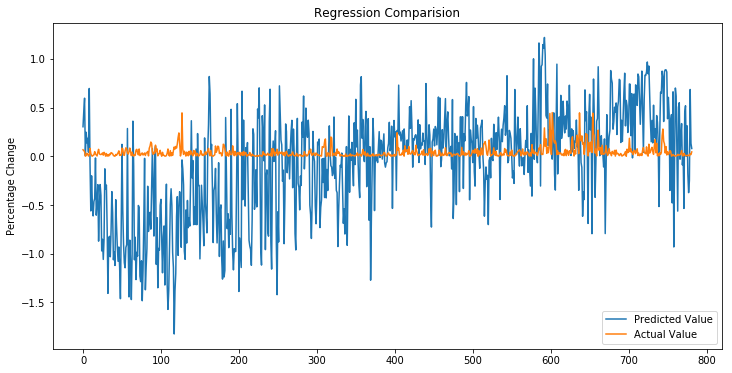

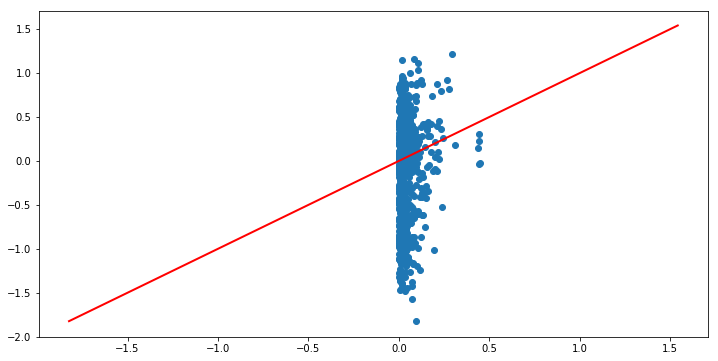

In [20]:
calculate_accuracy(AL, ytrains[coin])

In [21]:
def single_backtest(Xtrain, AL):
    
    bars = {}
    signals = {}
    

    signals['BTC'] = AL
    bars['BTC'] = Xtrain
    
    bt = Backtester(bars, signals, comission=0.1, maxper=0.01) #bars should contain 
    bt.perform_backtest()
    positions = bt.get_positions()
    bt.get_outcome()

C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor\BackTest\backtester.py:227: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  requiredcoins = closingsignals[self.positions['Coin'] == coin]
C:\Users\User\Desktop\Dissertation\CryptoPredictor\CryptoPredictor\BackTest\backtester.py:229: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if(closingsignals[self.positions['Coin'] == coin].shape[0] != 0): #this also happens automatically with the other warning


Portfolio Stats:
Total Return: -16.04%
Sharpe Ratio: -1.279 Calmar Ratio: -0.001 Sortino Ratio: -1.224 Maximum Drawdown: -16.35%

BTC Portfolio:
Total Return: 1530.2%
Sharpe Ratio: 2.187 Calmar Ratio: 0.021 Sortino Ratio: 2.678 Maximum Drawdown: -20.1%


ValueError: x and y must have same first dimension, but have shapes (758,) and (782,)

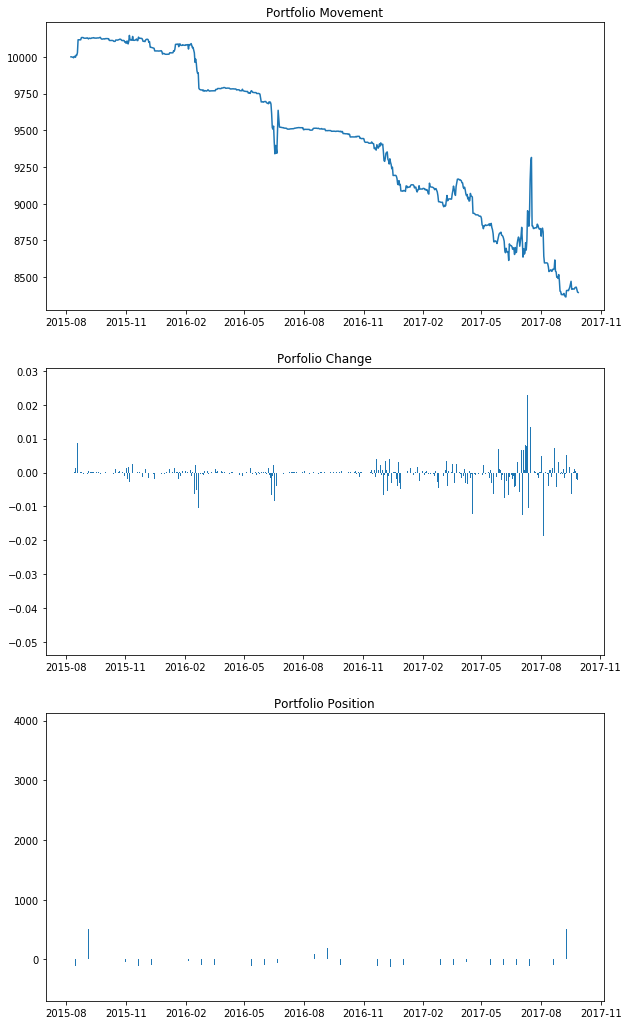

In [22]:
single_backtest(pd_Xtrains[symbol], AL)

In [76]:
pd_Xtrains[symbol].shape

(782, 24)

In [77]:
AL.shape

(782, 2)

In [93]:
df = pd.DataFrame(columns=['1', '2'])

In [138]:
dfs['BTC']

Open         Close          High       Low       Volume  \
Date                                                                         
1439010000    278.46000    278.310000    278.720000    277.37   709.882511   
1439013600    278.36000    277.990000    278.390000    277.98   194.195152   
1439017200    277.98000    278.070000    278.070000    277.96    54.156776   
1439020800    278.07000    278.340000    278.350000    278.06   136.694550   
1439024400    278.35000    278.340000    278.350000    278.33    94.217294   
1439028000    278.34000    278.350000    278.350000    278.34     1.606239   
1439031600    278.35000    276.390000    278.350000    275.01  1400.720156   
1439035200    276.13000    272.000000    276.170000    271.50  8499.187785   
1439038800    271.99000    266.820000    273.230000    266.00  7622.226899   
1439042400    266.82000    268.410000    269.190000    266.79  1451.778633   
1439046000    268.51000    269.080000    269.640000    268.22  1077.474044   
1439049600    269.07000    270.250000    271.900000    268.58  3242.007685   
1439053200    270.25000    270.020000    270.540000    270.00   641.666295   
1439056800    270.02000    269.010000    270.220000    268.80   899.885191   
1439060400    269.01000    268.790000    269.500000    268.64   636.156196   
1439064000    268.78000    268.780000    269.450000    268.77   253.067997   
1439067600    268.78000    266.740000    268.860000    266.66  2103.961028   
1439071200    266.75000    264.500000    266.920000    262.80  3798.113356   
1439074800    264.50000    261.340000    264.580000    260.62  3335.620345   
1439078400    261.43000    262.060000    262.300000    260.73  1691.085802   
1439082000    262.29000    262.540000    264.700000    261.96  2122.463408   
1439085600    262.63000    262.100000    263.300000    261.60   901.005534   
1439089200    262.04000    262.470000    264.480000    261.86   782.339875   
1439092800    262.48000    261.030000    262.490000    260.88   584.973159   
1439096400    261.09000    262.900000    263.400000    261.00   881.996264   
1439100000    262.82000    262.500000    262.980000    261.76   554.461617   
1439103600    262.50000    262.010000    262.880000    261.93   821.288221   
1439107200    261.97000    261.800000    263.000000    261.63   432.292785   
1439110800    261.80000    264.270000    265.000000    261.80   735.595039   
1439114400    264.21000    264.260000    264.280000    263.77   282.326312   
...                 ...           ...           ...       ...          ...   
1520305200  11262.00000  11250.000000  11274.000000  11181.00   841.912199   
1520308800  11249.00000  11279.000000  11328.000000  11180.00  1148.098061   
1520312400  11281.00000  11301.000000  11324.000000  11222.00   702.741796   
1520316000  11301.00000  11291.000000  11339.000000  11276.00   646.926644   
1520319600  11292.00000  11270.000000  11292.000000  11223.00   559.204696   
1520323200  11271.00000  11258.000000  11304.000000  11247.00  1070.447950   
1520326800  11258.00000  11270.000000  11311.000000  11256.00   504.903428   
1520330400  11270.00000  10942.000000  11270.000000  10906.00  6212.318805   
1520334000  10942.00000  10943.000000  10977.804736  10870.00  1980.332604   
1520337600  10943.00000  10928.000000  10970.000000  10871.00  1586.541318   
1520341200  10928.00000  10850.000000  10928.000000  10821.00  2606.577997   
1520344800  10850.00000  10993.000000  11016.000000  10850.00  1534.178599   
1520348400  10993.00000  10972.342800  11039.000000  10955.00  1281.286324   
1520352000  10972.71487  10954.000000  11003.000000  10922.00  1164.048294   
1520355600  10955.00000  10776.000000  10960.000000  10752.00  3213.702673   
1520359200  10776.00000  10722.000000  10881.000000  10678.00  2888.758974   
1520362800  10721.00000  10710.000000  10725.000000  10567.00  3855.570881   
1520366400  10711.00000  10651.000000  10718.000000  10582.00  1443.576782   
1520370000  10650.00000  10776.000000  10

In [23]:
from keras.utils.vis_utils import plot_model

In [26]:
plot_model(convModel)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [25]:
import pydot